In [1]:
import warnings
warnings.filterwarnings(action="ignore")

import pandas as pd 
import numpy as np
from scipy.fft import fft
from nilmtk import DataSet, MeterGroup
from nilmtk.utils import print_dict
import sys
sys.path.append('../../pynilm')
from plotly import express as px # type: ignore
from plotly import io as pio # type: ignore
pio.renderers.default = 'vscode'

from matplotlib import pyplot as plt

In [2]:
path_redd = '../data/redd.h5'
redd = DataSet(path_redd)
BUILDING_ID = 3
SAMPLE = 1

In [3]:
# Access data for house 3
building = redd.buildings[BUILDING_ID]
# Get mains data and resample to 1Hz
mains = building.elec.mains()

#mains_df = mains.power_series_all_data().resample('1S').mean()

if isinstance(mains, MeterGroup):
    metergroup = mains
else:
    metergroup = MeterGroup(meters=[mains])

# Fill any NaNs with interpolation or forward/backward fill
mains_df = next(metergroup.load(
            sample_period=SAMPLE, 
            physical_quantity='power', 
            ac_type='apparent'))

mains_df = mains_df.fillna(0)

# Convert Series to DataFrame
mains_df = mains_df.reset_index()

# Rename the columns for clarity
mains_df.columns = ['timestamp', 'mains']

# Ensure 'timestamp' column is in datetime format
mains_df['timestamp'] = pd.to_datetime(mains_df['timestamp'])

# Set the index as the timestamp
mains_df.set_index('timestamp', inplace=True)

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


In [4]:
# Define a function to calculate Amplitude Spectrum and Phase Spectrum
def calculate_spectrum(data):
    # Perform FFT
    fft_values = fft(data)
    
    # Compute Amplitude Spectrum and Phase Spectrum
    amplitude_spectrum = np.abs(fft_values)
    phase_spectrum = np.angle(fft_values)
    
    return amplitude_spectrum, phase_spectrum

# Define a function to extract features
def extract_features(data):
    features = pd.DataFrame()
    
    # Calculate Amplitude Spectrum and Phase Spectrum for power means
    #amplitude_spectrum, phase_spectrum = calculate_spectrum(data['mains'])
    
    # Add features to DataFrame
    features['mains'] = data['mains']
    #features['amplitude_spectrum'] = amplitude_spectrum
    #features['phase_spectrum'] = phase_spectrum
    
    features = features.dropna()
    return features

# Extract features from mains data
features = extract_features(mains_df)

In [5]:
threshold_list = list()
# Create a mapping for appliance names to ensure unique identifiers
appliance_counter = {}
# Iterate through each appliance and create labels
for meter in building.elec.submeters().meters:
    
    if isinstance(meter, MeterGroup):
        for submeter in meter.submeters().meters:
            appliance_name = submeter.label()
            # Ensure a unique name for each appliance
            if appliance_name in appliance_counter:
                appliance_counter[appliance_name] += 1
            else:
                appliance_counter[appliance_name] = 1

            unique_appliance_name = f"{appliance_name}{appliance_counter[appliance_name]:02d}"

            metergroup = MeterGroup(meters=[submeter])
            result = dict()
            result['appliance'] = unique_appliance_name
            result['threshold'] = submeter.on_power_threshold()
            threshold_list.append(result)
    else:
        appliance_name = meter.label()
        # Ensure a unique name for each appliance
        if appliance_name in appliance_counter:
            appliance_counter[appliance_name] += 1
        else:
            appliance_counter[appliance_name] = 1

        unique_appliance_name = f"{appliance_name}{appliance_counter[appliance_name]:02d}"

        metergroup = MeterGroup(meters=[meter])
        result = dict()
        result['appliance'] = unique_appliance_name
        result['threshold'] = meter.on_power_threshold()

        threshold_list.append(result)

threshold_list = pd.DataFrame(threshold_list)
threshold_list.to_csv('../data/appliance_threshold.csv', index=False)

In [7]:
# Initialize a DataFrame to store labels
labels_activations_df = pd.DataFrame(index=features.index)

# Initialize a DataFrame to store labels
labels_is_on_df = pd.DataFrame(index=features.index)

# Create a mapping for appliance names to ensure unique identifiers
appliance_counter = {}

# Iterate through each appliance and create labels
for meter in building.elec.submeters().meters:
    if isinstance(meter, MeterGroup):
        for submeter in meter.submeters().meters:
            appliance_name = submeter.label()
            # Ensure a unique name for each appliance
            if appliance_name in appliance_counter:
                appliance_counter[appliance_name] += 1
            else:
                appliance_counter[appliance_name] = 1

            unique_appliance_name = f"{appliance_name}{appliance_counter[appliance_name]:02d}"

            metergroup = MeterGroup(meters=[submeter])

            # Get appliance power series and resample to 1Hz
            #appliance_series = submeter.power_series_all_data().resample('1S').mean()
            appliance_series = next(metergroup.load(
                            sample_period=SAMPLE, 
                            physical_quantity='power', 
                            ac_type='active'))
            appliance_series = appliance_series.fillna(0)  # Fill NaNs with 0 (assuming appliance is off)
            
            # Convert Series to DataFrame
            appliance_series = appliance_series.reset_index()

            # Rename the columns for clarity
            appliance_series.columns = ['timestamp', unique_appliance_name]

            # Ensure 'timestamp' column is in datetime format
            appliance_series['timestamp'] = pd.to_datetime(appliance_series['timestamp'])

            # Set the index as the timestamp
            appliance_series.set_index('timestamp', inplace=True)

            # Create activations float
            labels_activations_df[unique_appliance_name] = appliance_series
            # Create binary labels: 1 if the appliance is on, 0 if off
            labels_is_on_df[unique_appliance_name] = (appliance_series > submeter.on_power_threshold()).astype(int)  # Threshold if on/off
    else:
        appliance_name = meter.label()
        # Ensure a unique name for each appliance
        if appliance_name in appliance_counter:
            appliance_counter[appliance_name] += 1
        else:
            appliance_counter[appliance_name] = 1

        unique_appliance_name = f"{appliance_name}{appliance_counter[appliance_name]:02d}"

        metergroup = MeterGroup(meters=[meter])

        # Get appliance power series and resample to 1Hz
        #appliance_series = meter.power_series_all_data().resample('1S').mean()
        appliance_series = next(metergroup.load(
                            sample_period=SAMPLE, 
                            physical_quantity='power', 
                            ac_type='active'))
        appliance_series = appliance_series.fillna(0)  # Fill NaNs with 0 (assuming appliance is off)
        
        # Convert Series to DataFrame
        appliance_series = appliance_series.reset_index()

        # Rename the columns for clarity
        appliance_series.columns = ['timestamp', unique_appliance_name]

        # Ensure 'timestamp' column is in datetime format
        appliance_series['timestamp'] = pd.to_datetime(appliance_series['timestamp'])

        # Set the index as the timestamp
        appliance_series.set_index('timestamp', inplace=True)

        # Create activations float
        labels_activations_df[unique_appliance_name] = appliance_series
        # Create binary labels: 1 if the appliance is on, 0 if off
        labels_is_on_df[unique_appliance_name] = (appliance_series > meter.on_power_threshold()).astype(int)  # Threshold if on/off

# Align labels with the features index
labels_activations_df = labels_activations_df.loc[features.index].fillna(0)
labels_is_on_df = labels_is_on_df.loc[features.index].fillna(0)

# Combine features and the labels into one DataFrame
df_activations = features.join(labels_activations_df)
df_is_on = features.join(labels_is_on_df)


Loading data for meter ElecMeterID(instance=3, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=5, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=6, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=7, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=8, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=9, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=3, dataset='REDD')     
Done loading data all meters for this chunk.

In [8]:
df_activations.head().T

timestamp,2011-04-16 01:11:27-04:00,2011-04-16 01:11:28-04:00,2011-04-16 01:11:29-04:00,2011-04-16 01:11:30-04:00,2011-04-16 01:11:31-04:00
mains,757.089966,758.890015,758.889954,758.640015,756.640015
Sockets01,0.000000,0.000000,0.000000,2.000000,2.000000
Sockets02,0.000000,0.000000,0.000000,0.000000,0.000000
Light01,0.000000,0.000000,0.000000,1.000000,1.000000
CE appliance01,0.000000,0.000000,0.000000,126.000000,126.000000
Fridge01,0.000000,0.000000,0.000000,119.000000,119.000000
Waste disposal unit01,0.000000,0.000000,0.000000,0.000000,0.000000
Dish washer01,0.000000,0.000000,0.000000,0.000000,0.000000
Electric furnace01,0.000000,0.000000,0.000000,5.000000,5.000000
Light02,0.000000,0.000000,0.000000,180.000000,180.000000


In [9]:
df_is_on.head().T

timestamp,2011-04-16 01:11:27-04:00,2011-04-16 01:11:28-04:00,2011-04-16 01:11:29-04:00,2011-04-16 01:11:30-04:00,2011-04-16 01:11:31-04:00
mains,757.089966,758.890015,758.889954,758.640015,756.640015
Sockets01,0.000000,0.000000,0.000000,0.000000,0.000000
Sockets02,0.000000,0.000000,0.000000,0.000000,0.000000
Light01,0.000000,0.000000,0.000000,0.000000,0.000000
CE appliance01,0.000000,0.000000,0.000000,1.000000,1.000000
Fridge01,0.000000,0.000000,0.000000,1.000000,1.000000
Waste disposal unit01,0.000000,0.000000,0.000000,0.000000,0.000000
Dish washer01,0.000000,0.000000,0.000000,0.000000,0.000000
Electric furnace01,0.000000,0.000000,0.000000,0.000000,0.000000
Light02,0.000000,0.000000,0.000000,1.000000,1.000000


In [10]:
df_activations.shape, df_is_on.shape

((3870507, 21), (3870507, 21))

In [11]:
df_activations.to_csv('../data/redd_active_value_f1hz.csv')
df_is_on.to_csv('../data/redd_active_binary_f1hz.csv')

In [12]:
def chunkify(df: pd.DataFrame, chunk_size: int, stride: int = 1):
    start = 0
    length = df.shape[0]

    # If DF is smaller than the chunk, return the DF
    if length <= chunk_size:
        return df[:]

    # Producing individual chunks
    dfs = []
    # while start + chunk_size <= length:
    #     dfs.append(df[start:chunk_size + start])
    #     start = start + chunk_size
    for i in range(0, length - chunk_size, stride):
        dfs.append(df[i:i + chunk_size])
    return dfs

appliances = [c for c in df_activations.columns.values if not c in ['mains','amplitude_spectrum','phase_spectrum']]

df_data = chunkify(df_activations, 1000, 1000)
df_data_ac = chunkify(df_is_on, 1000, 1000)


In [13]:
import random

appliances = ['Fridge01','Dish washer01','Microwave01','Washer dryer01','Washer dryer02']

Fridge01:


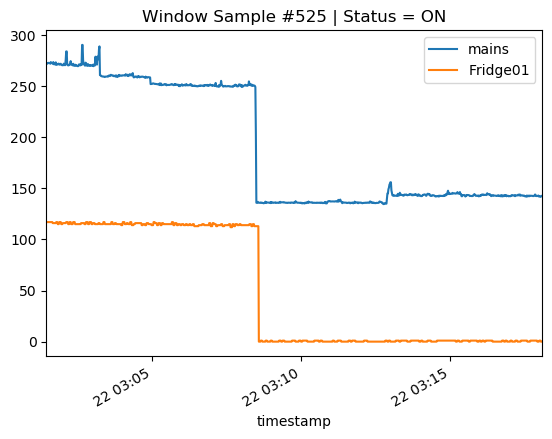

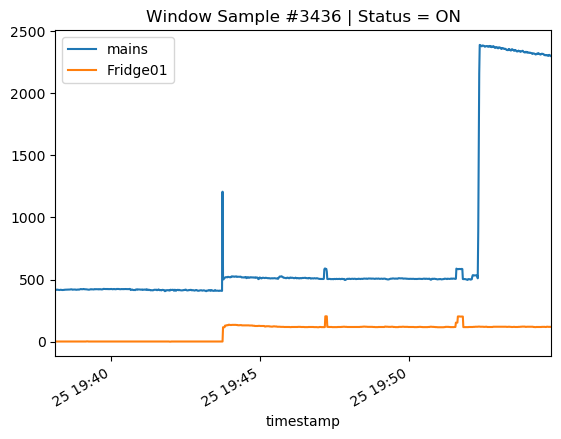

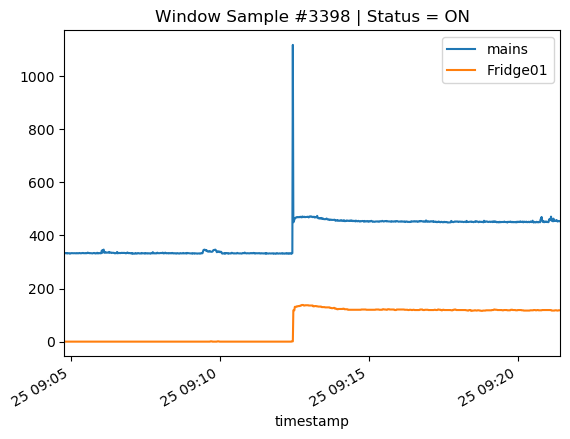

Dish Washer01:


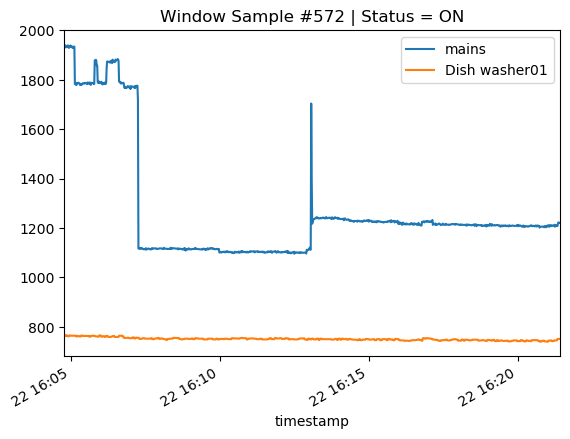

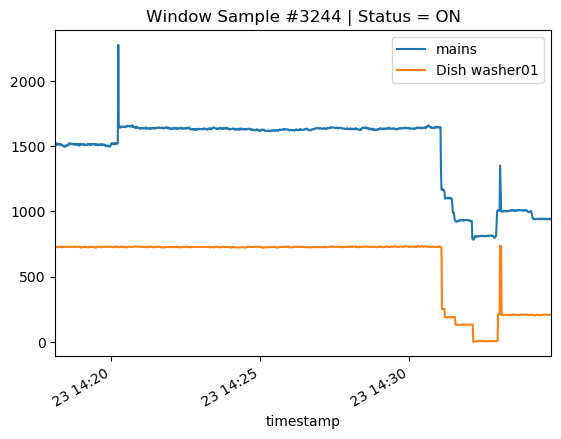

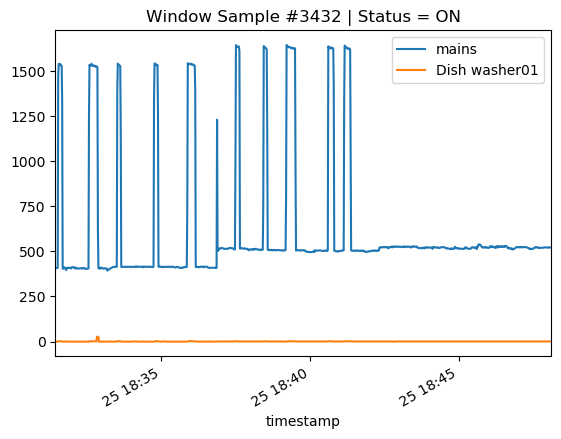

Microwave01:


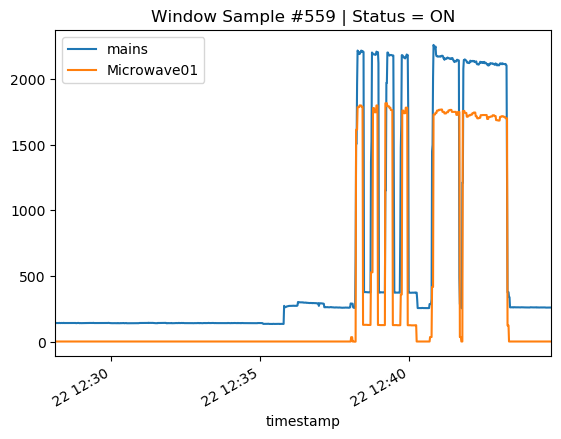

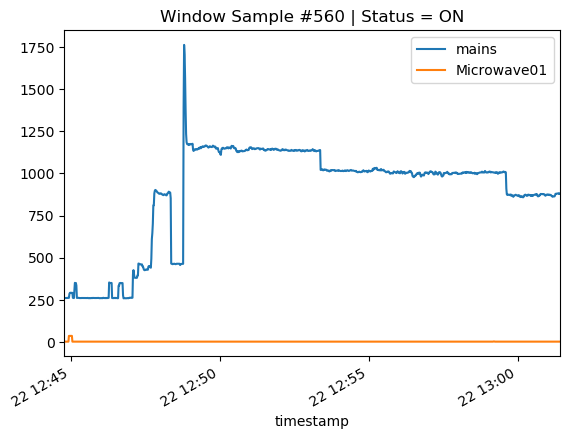

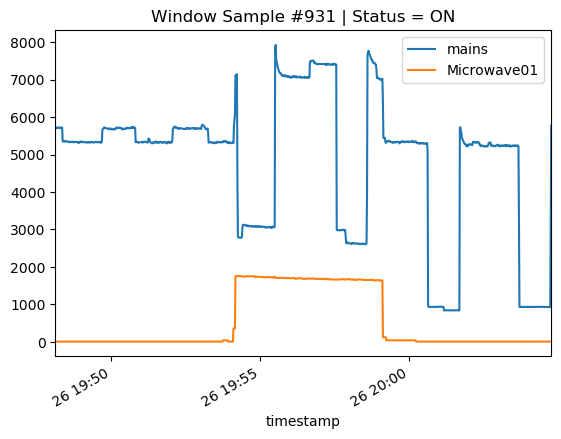

Washer Dryer01:


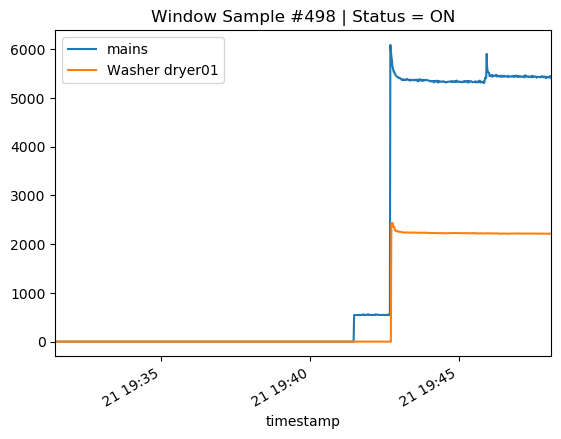

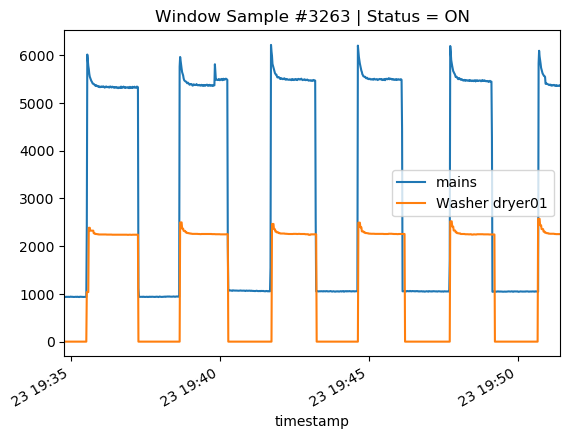

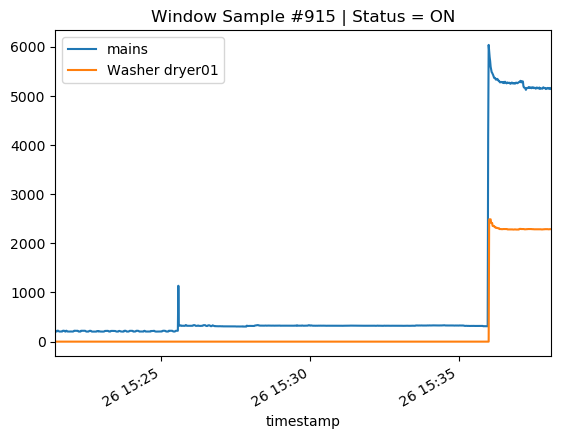

Washer Dryer02:


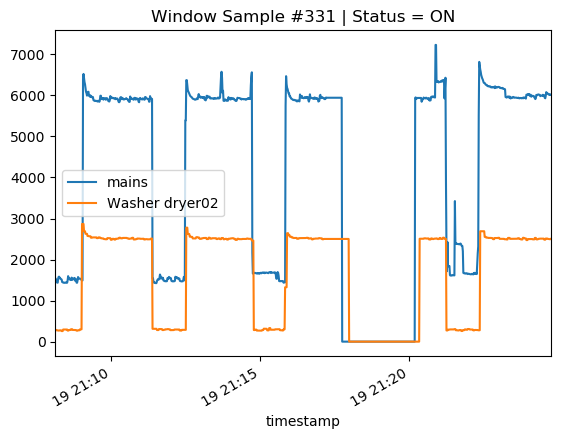

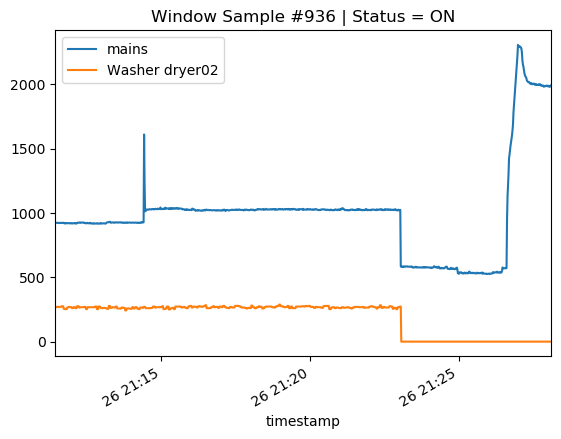

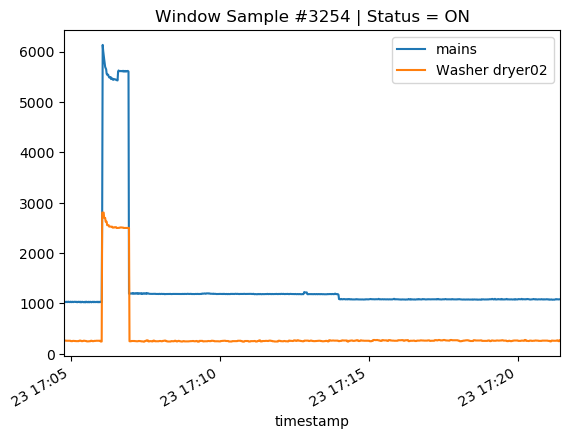

In [14]:
for a in appliances:
    print(f'{a.title()}:')
    
    l = len(df_data)

    samples = 0
    for i in range(l):
        
        # Obtener un número aleatorio en el rango [0, len(df_data) - 1]
        random_index = random.randint(0, l - 1)

        status = df_data_ac[random_index][a].max()
        
        if status>0 and samples < 3:
            df = df_data[random_index][['mains', a]]
            df.plot()
            plt.title(f'Window Sample #{random_index} | Status = {"ON" if status > 0 else "OFF"}')
            plt.show()
            samples += 1
        
        if samples == 3:
            break